In [1]:
import numpy as np
import pandas as pd
import datetime
import gc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew in

In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_hist_trans = pd.read_csv('../input/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../input/new_merchant_transactions.csv')

In [3]:
df_hist_trans['purchase_amount'] = np.exp(df_hist_trans['purchase_amount'])
df_new_merchant_trans['purchase_amount'] = np.exp(df_new_merchant_trans['purchase_amount'])

In [4]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [5]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [6]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [7]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

42

In [8]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

28

In [9]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,9,23,35,7,...,6.0,0.260870,0.0,0.000000,23.0,1.658319e+108,1.381361e+36,54.0,2.347826,243.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,12,24,50,7,...,0.0,0.000000,0.0,0.000000,6.0,1.658319e+108,3.557623e+25,56.0,9.333333,273.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,10,14,22,7,...,1.0,1.000000,0.0,0.000000,1.0,7.789907e+26,1.381361e+36,0.0,0.000000,243.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,6,16,20,7,...,3.0,0.428571,1.0,0.142857,7.0,2.369028e+107,1.973373e+35,41.0,5.857143,254.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,4,22,17,7,...,12.0,0.333333,2.0,0.055556,36.0,1.842577e+107,3.624714e+107,57.0,1.583333,243.0


In [10]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [11]:
list_outlier_idx = df_train[df_train.outliers == 1].index.tolist()

In [12]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [13]:
high_importance_features = [
    "hist_month_diff_mean", 
    "hist_authorized_flag_mean", 
    "hist_category_1_sum", 
    "hist_month_lag_mean", 
    "new_hist_purchase_amount_sum", 
    "new_hist_purchase_date_uptonow"
]

#smoothing
for col in high_importance_features:
    df_train[col] = np.where(df_train[col].values==0, 0.001, df_train[col].values)
    df_test[col] = np.where(df_test[col].values==0, 0.001, df_test[col].values)


for i in range(len(high_importance_features)):
    for j in range(len((high_importance_features)))[i+1:]:
        col1 = high_importance_features[i]
        col2 = high_importance_features[j]
        new_col_name = "{c1}__div__{c2}".format(c1=col1, c2=col2)
        
        df_train[new_col_name] = df_train[col1] / df_train[col2]
        df_test[new_col_name] = df_test[col1] / df_test[col2]

In [14]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [15]:
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/new_merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/prosperity_merchants_latest.csv")
df_train, df_test = merge_new_feature("../input/merchants_numerical_features.csv")
df_train, df_test = merge_new_feature("../input/merchants_item_scale_feature.csv")
df_train, df_test = merge_new_feature("../input/purchase_pattern.csv")
df_train, df_test = merge_new_feature("../input/purchase_pettern_nmf.csv")
df_train, df_test = merge_new_feature("../input/purchase_amount_pettern_nmf.csv")
df_train, df_test = merge_new_feature("../input/merchants_category.csv")
df_train, df_test = merge_new_feature("../input/fifa_score.csv")
df_train, df_test = merge_new_feature("../input/fifa_score2.csv")
df_train, df_test = merge_new_feature("../input/fifa_score3.csv")
df_train, df_test = merge_new_feature("../input/fifa_score4.csv")
df_train, df_test = merge_new_feature("../input/fifa_not_purchase_score.csv")

In [16]:
df_train["Null_count"] = df_train.isnull().sum(axis=1)
df_test["Null_count"] = df_test.isnull().sum(axis=1)

In [17]:
dont_use = ['card_id', 'first_active_month','second_active_date','diff_first_and_second','target','outliers', 'category_1_Y_std']

df_train_columns = [c for c in df_train.columns if c not in dont_use]
target = df_train['target']
target_outlier = df_train["outliers"]

In [18]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.73708	valid_1's rmse: 3.77405
[200]	training's rmse: 3.66733	valid_1's rmse: 3.73223
[300]	training's rmse: 3.6188	valid_1's rmse: 3.70919
[400]	training's rmse: 3.58122	valid_1's rmse: 3.69549
[500]	training's rmse: 3.55188	valid_1's rmse: 3.6858
[600]	training's rmse: 3.52711	valid_1's rmse: 3.67823
[700]	training's rmse: 3.50639	valid_1's rmse: 3.67333
[800]	training's rmse: 3.48763	valid_1's rmse: 3.66928
[900]	training's rmse: 3.47079	valid_1's rmse: 3.66613
[1000]	training's rmse: 3.45584	valid_1's rmse: 3.66354
[1100]	training's rmse: 3.44132	valid_1's rmse: 3.66097
[1200]	training's rmse: 3.42779	valid_1's rmse: 3.6589
[1300]	training's rmse: 3.41511	valid_1's rmse: 3.65714
[1400]	training's rmse: 3.40302	valid_1's rmse: 3.65546
[1500]	training's rmse: 3.39124	valid_1's rmse: 3.65404
[1600]	training's rmse: 3.38005	valid_1's rmse: 3.65305
[1700]	training's rmse: 3.36912	valid_1's rmse

[1700]	training's rmse: 3.36	valid_1's rmse: 3.66768
[1800]	training's rmse: 3.34958	valid_1's rmse: 3.66751
[1900]	training's rmse: 3.33937	valid_1's rmse: 3.66714
[2000]	training's rmse: 3.32909	valid_1's rmse: 3.66708
[2100]	training's rmse: 3.31942	valid_1's rmse: 3.6668
[2200]	training's rmse: 3.31021	valid_1's rmse: 3.66662
[2300]	training's rmse: 3.30136	valid_1's rmse: 3.66649
[2400]	training's rmse: 3.29251	valid_1's rmse: 3.66628
[2500]	training's rmse: 3.28388	valid_1's rmse: 3.66637
[2600]	training's rmse: 3.27499	valid_1's rmse: 3.66648
[2700]	training's rmse: 3.2669	valid_1's rmse: 3.66661
[2800]	training's rmse: 3.25849	valid_1's rmse: 3.66655
Early stopping, best iteration is:
[2406]	training's rmse: 3.2921	valid_1's rmse: 3.66625
fold 4
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.7367	valid_1's rmse: 3.7767
[200]	training's rmse: 3.66574	valid_1's rmse: 3.73549
[300]	training's rmse: 3.61633	valid_1's rmse: 3.71348
[400]	trai

3.645338860127743

In [19]:
# score:  3.6467757129353053

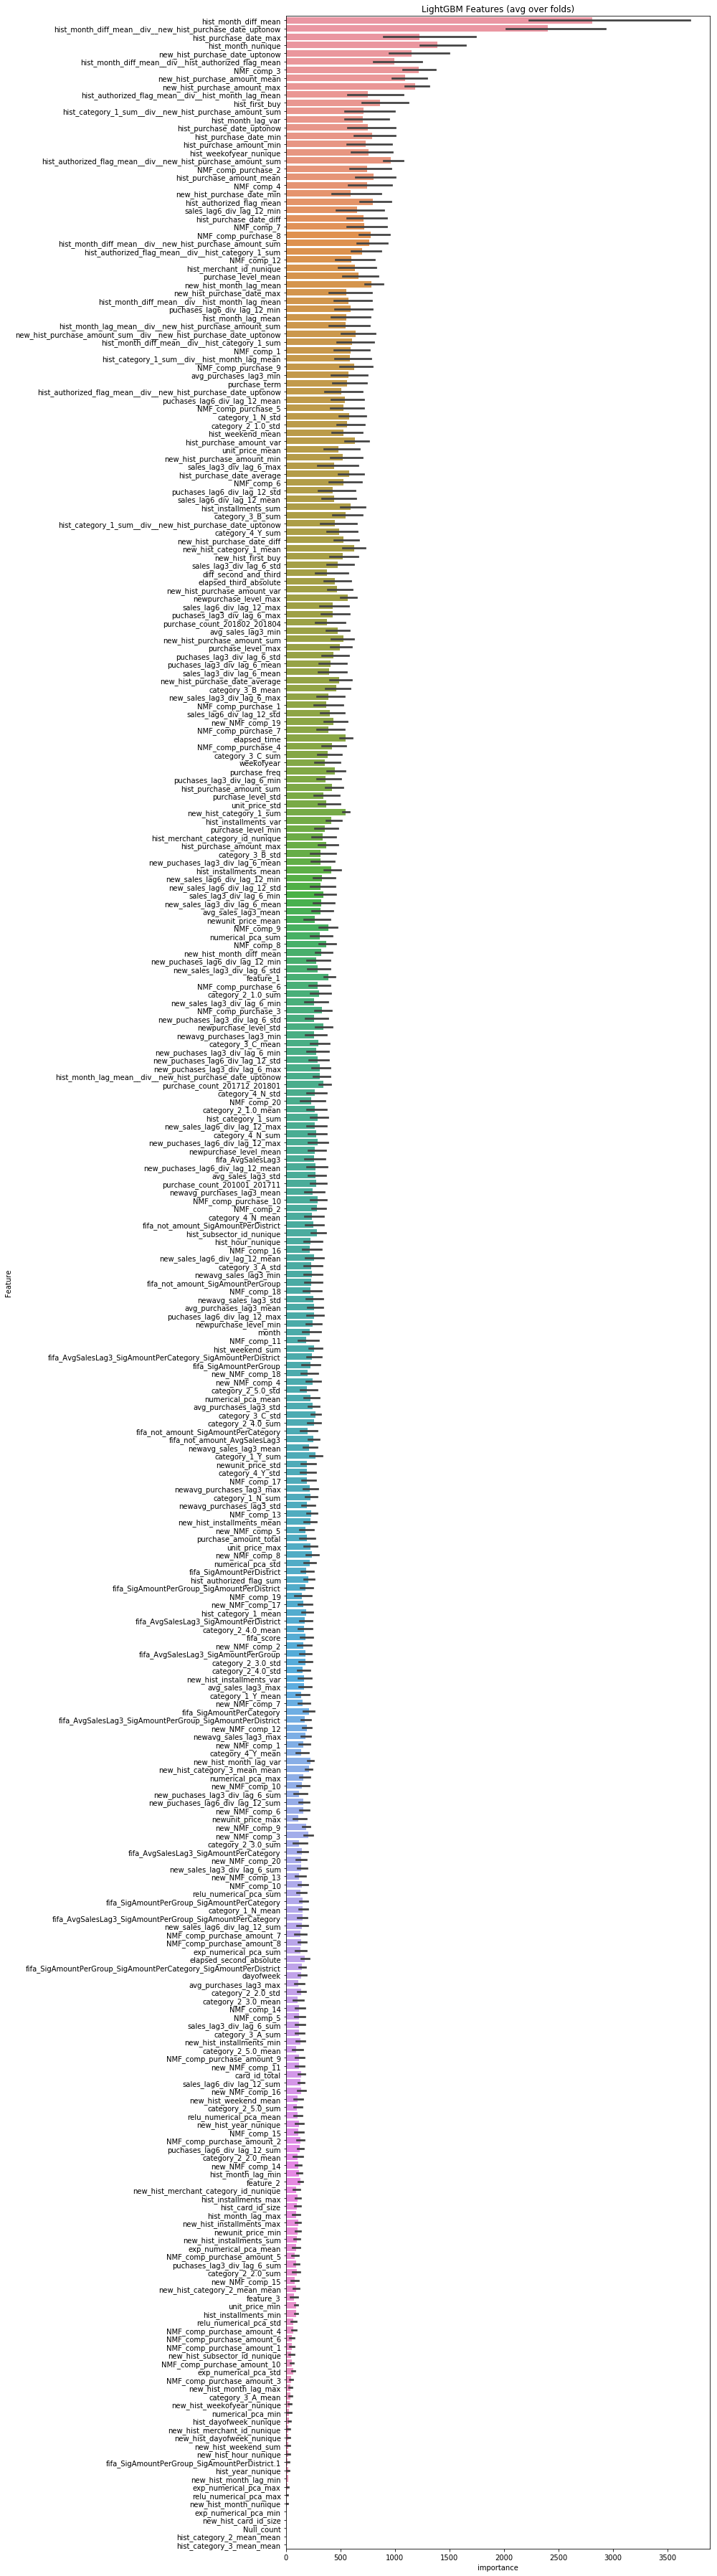

In [20]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [21]:
df_train2 = df_train[df_train.target >= -20].reset_index(drop=True)
target2 = df_train2["target"]

#original
param2 = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train2))
predictions2 = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train2,df_train2['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train2.iloc[trn_idx][df_train_columns], label=target2.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train2.iloc[val_idx][df_train_columns], label=target2.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param2, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train2.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions2 += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target2))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.65317	valid_1's rmse: 1.65214
[200]	training's rmse: 1.61834	valid_1's rmse: 1.61771
[300]	training's rmse: 1.59791	valid_1's rmse: 1.59833
[400]	training's rmse: 1.58458	valid_1's rmse: 1.5862
[500]	training's rmse: 1.57513	valid_1's rmse: 1.57821
[600]	training's rmse: 1.56796	valid_1's rmse: 1.57267
[700]	training's rmse: 1.56209	valid_1's rmse: 1.56858
[800]	training's rmse: 1.55719	valid_1's rmse: 1.56556
[900]	training's rmse: 1.55284	valid_1's rmse: 1.5632
[1000]	training's rmse: 1.5489	valid_1's rmse: 1.56126
[1100]	training's rmse: 1.54531	valid_1's rmse: 1.55971
[1200]	training's rmse: 1.54197	valid_1's rmse: 1.55844
[1300]	training's rmse: 1.53885	valid_1's rmse: 1.55737
[1400]	training's rmse: 1.53589	valid_1's rmse: 1.55645
[1500]	training's rmse: 1.53306	valid_1's rmse: 1.55568
[1600]	training's rmse: 1.53036	valid_1's rmse: 1.55506
[1700]	training's rmse: 1.52779	valid_1's rmse

KeyboardInterrupt: 

In [ ]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [ ]:
df_prediction = pd.DataFrame({"prediction1":predictions, "prediction2":predictions2})
df_prediction

In [ ]:
predictions3 = np.zeros(df_prediction.shape[0])
for i, r in df_prediction.iterrows():
    if r[0] < 0 :
        predictions3[i] = r[0]
    else:
        predictions3[i] = r[1]
df_prediction["prediction3"] = predictions3

In [54]:
df_prediction

,prediction1,prediction2,prediction3
0,-1.856965,-0.489123,-1.856965
1,-0.315682,-0.244274,-0.315682
2,-0.967476,-0.488852,-0.967476
3,-0.115888,-0.088194,-0.115888
4,-1.644578,-1.848877,-1.644578
5,-0.009206,0.584500,-0.009206
6,0.040183,0.164713,0.164713
7,0.588900,0.865178,0.865178
8,-0.675868,-0.685847,-0.675868
9,-0.981038,-0.279191,-0.981038


In [55]:
final_predictions = df_prediction.prediction3.values

In [56]:
# import optuna

# def objective(trial):
#     train_x, test_x, train_y, test_y = train_test_split(df_train[df_train_columns], target, test_size=0.20, random_state=4590)
    
#     dtrain = lgb.Dataset(train_x, label=train_y)
#     dval = lgb.Dataset(test_x, label=test_y)

#     num_round = trial.suggest_int('num_round', 1, 10000)
#     param = {
#         'objective': 'regression', 
#         'metric': 'rmse',
#         'verbosity': -1,
#         'feature_fraction': trial.suggest_loguniform('feature_fraction', 0.8, 0.95),
#         'bagging_fraction': trial.suggest_loguniform('bagging_fraction', 0.8, 0.95),
#         'bagging_seed': 11,
#         'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
#         'num_leaves': trial.suggest_int('num_leaves', 10, 100),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
#         'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
#         'min_data_in_leaf':  trial.suggest_int('min_data_in_leaf', 10, 1000),
#         'lambda_l1':  trial.suggest_loguniform('lambda_l1', 1e-2, 1.0)
#     }

#     if param['boosting_type'] == 'dart':
#         param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-4, 1.0)
#         param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-4, 1.0)
#     if param['boosting_type'] == 'goss':
#         param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
#         param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])

#     gbm = lgb.train(param, dtrain, num_round, valid_sets = [dtrain, dval], verbose_eval=100, early_stopping_rounds=400)
#     preds = gbm.predict(test_x)
#     pred_labels = np.rint(preds)
#     rmse = np.sqrt(mean_squared_error(test_y, pred_labels))
#     return rmse

# study = optuna.create_study()
# study.optimize(objective, n_trials=20)

# print('Number of finished trials: {}'.format(len(study.trials)))

# print('Best trial:')
# trial = study.best_trial

# print('  Value: {}'.format(trial.value))

# print('  Params: ')
# for key, value in trial.params.items():
#     print('    {}: {}'.format(key, value))

In [57]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = final_predictions
sub_df.to_csv("../output/submission_model20181225.csv", index=False)